# Stress gradient normal to a defined node {#stress_gradient_path}

This example shows how to plot a stress gradient normal to a selected
node. Because the example is based on creating a path along the normal,
the selected node must be on the surface of the geometry. A path is
created of a defined length.


Import the DPF-Core module as `dpf` and import the included examples
file and `DpfPlotter`.


In [1]:
import matplotlib.pyplot as plt

from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops
from ansys.dpf.core.plotter import DpfPlotter

Open an example and print out the `Model` object. The
`Model <ansys.dpf.core.model.Model>`{.interpreted-text role="class"}
class helps to organize access methods for the result by keeping track
of the operators and data sources used by the result file.

Printing the model displays:

-   Analysis type
-   Available results
-   Size of the mesh
-   Number of results
-   Unit


In [2]:
path = examples.download_hemisphere()
model = dpf.Model(path)
print(model)

DPF Model
------------------------------
Static analysis
Unit system: NMM: mm, ton, N, s, mA, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  reaction_force: Nodal Force   
     -  stress: ElementalNodal Stress 
     -  elemental_volume: Elemental Volume
     -  stiffness_matrix_energy: Elemental Energy-stiffness matrix
     -  artificial_hourglass_energy: Elemental Hourglass Energy
     -  thermal_dissipation_energy: Elemental thermal dissipation energy
     -  kinetic_energy: Elemental Kinetic Energy
     -  co_energy: Elemental co-energy
     -  incremental_energy: Elemental incremental energy
     -  elastic_strain: ElementalNodal Strain
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  10741 nodes 
  3011 elements 
  Unit: mm 
  With solid (3D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 1 
Cumulative     Time (s)       LoadStep   

Define the node ID normal to plot the a stress gradient


In [3]:
node_id = 1928

Print the mesh unit


In [4]:
unit = model.metadata.meshed_region.unit
print("Unit: %s" % unit)

Unit: mm


`depth` defines the length/depth that the path penetrates to. While
defining `depth` make sure you use the correct mesh unit. `delta`
defines distance between consecutive points on the path.


In [5]:
depth = 10  # in mm
delta = 0.1  # in mm

Get the meshed region


In [6]:
mesh = model.metadata.meshed_region

Get Equivalent stress fields container.


In [7]:
stress_fc = model.results.stress().eqv().eval()

Define Nodal scoping. Make sure to define `"Nodal"` as the requested
location, important for the
`normals <ansys.dpf.core.operators.geo.normals.normals>`{.interpreted-text
role="class"} operator.


In [8]:
nodal_scoping = dpf.Scoping(location=dpf.locations.nodal)
nodal_scoping.ids = [node_id]

Get Skin Mesh because
`normals <ansys.dpf.core.operators.geo.normals.normals>`{.interpreted-text
role="class"} operator requires Shells as input.


In [9]:
skin_mesh = ops.mesh.skin(mesh=mesh)
skin_meshed_region = skin_mesh.outputs.mesh.get_data()

Get normal at a node using
`normals <ansys.dpf.core.operators.geo.normals.normals>`{.interpreted-text
role="class"} operator.


In [10]:
normal = ops.geo.normals()
normal.inputs.mesh.connect(skin_meshed_region)
normal.inputs.mesh_scoping.connect(nodal_scoping)
normal_vec_out_field = normal.outputs.field.get_data()

The normal vector is along the surface normal. You need to invert the
vector using
`scale <ansys.dpf.core.operators.math.scale.scale>`{.interpreted-text
role="class"} operator inwards in the geometry, to get the path
direction.


In [11]:
normal_vec_in_field = ops.math.scale(field=normal_vec_out_field, ponderation=-1.0)
normal_vec_in = normal_vec_in_field.outputs.field.get_data().data[0]

Get nodal coordinates, they serve as the first point on the line.


In [12]:
node = mesh.nodes.node_by_id(node_id)
line_fp = node.coordinates

Create 3D line equation.


In [13]:
fx = lambda t: line_fp[0] + normal_vec_in[0] * t
fy = lambda t: line_fp[1] + normal_vec_in[1] * t
fz = lambda t: line_fp[2] + normal_vec_in[2] * t

Create coordinates using 3D line equation.


In [14]:
coordinates = [[fx(t * delta), fy(t * delta), fz(t * delta)] for t in range(int(depth / delta))]
flat_coordinates = [entry for data in coordinates for entry in data]

Create field for coordinates of the path.


In [15]:
field_coord = dpf.fields_factory.create_3d_vector_field(len(coordinates))
field_coord.data = flat_coordinates
field_coord.scoping.ids = list(range(1, len(coordinates) + 1))

Map results on the path.


In [16]:
mapping_operator = ops.mapping.on_coordinates(
    fields_container=stress_fc, coordinates=field_coord, create_support=True, mesh=mesh
)
fields_mapped = mapping_operator.outputs.fields_container()

Request the mapped field data and its mesh.


In [17]:
field_m = fields_mapped[0]
mesh_m = field_m.meshed_region

Create stress vs length chart.


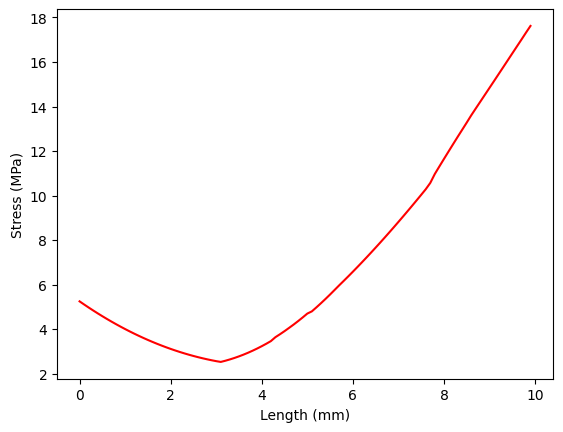

In [18]:
x_initial = 0.0
length = [x_initial + delta * index for index in range(len(field_m.data))]
plt.plot(length, field_m.data, "r")
plt.xlabel("Length (%s)" % mesh.unit)
plt.ylabel("Stress (%s)" % field_m.unit)
plt.show()

Create a plot to add both meshes, `mesh_m` (the mapped mesh) and `mesh`
(the original mesh)


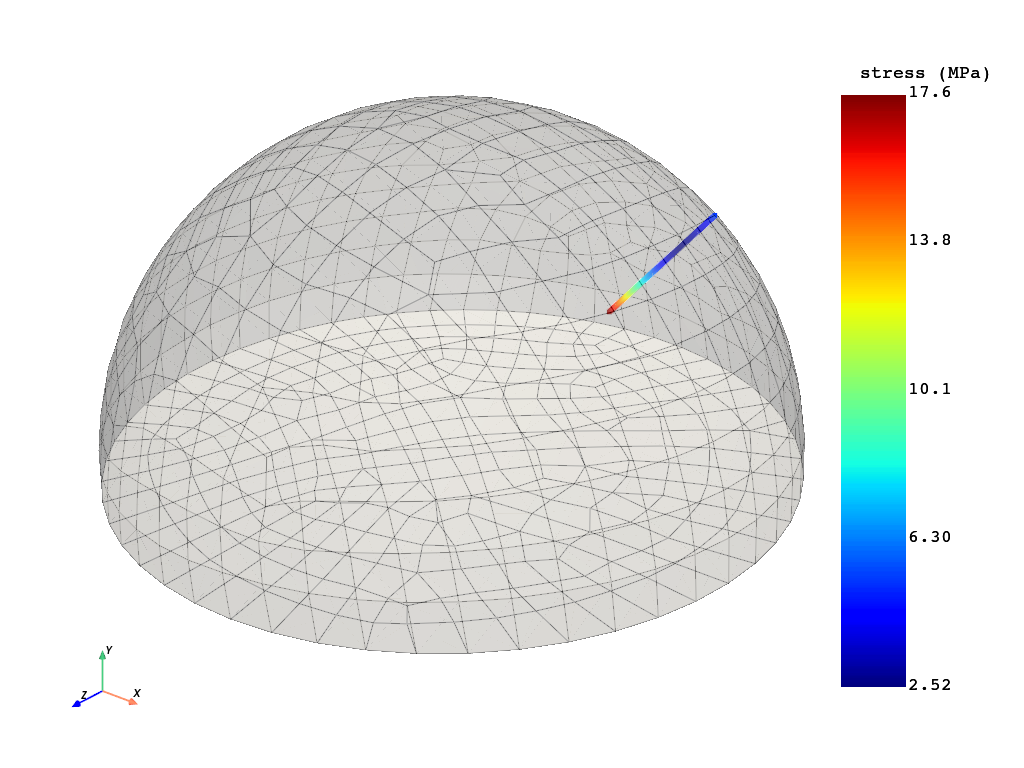

In [19]:
pl = DpfPlotter()
pl.add_field(field_m, mesh_m)
pl.add_mesh(mesh, style="surface", show_edges=True, color="w", opacity=0.3)
pl.show_figure(
    show_axes=True,
    cpos=[(62.687, 50.119, 67.247), (5.135, 6.458, -0.355), (-0.286, 0.897, -0.336)],
)